# Evaluation by MRI characteristics

In [1]:

import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting
import cmbnet.utils.utils_evaluation as utils_eval
import ast


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)


In [2]:
eval_dir = "../../data-misc/evaluations"

l1_dirs = ["Scratch-Pretrained-FineTuned"]  # winner
l2_dirs = ["predict_cmb_valid", "predict_cmb_dou", "predict_cmb_crb"]
l3_dirs = ["valloss"]

(
    df_classification,
    df_detection,
    df_segmentation,
    detection_details,
    segmentation_details,
    cmb_results,
) = utils_eval.load_evaluation_data(
    eval_dir, l1_dirs, l2_dirs, l3_dirs
)

In [3]:
# Flatten the data into a list
flattened_data = []
for key, entries in detection_details.items():
    if not entries:
        continue
    for entry in entries:
        # Combine key tuple and entry dictionary
        combined_entry = dict(zip(['Model', 'Dataset', 'Criteria', 'Location'], key))
        combined_entry.update(entry)
        flattened_data.append(combined_entry)

# Create a DataFrame
df_detection_serieslevel = pd.DataFrame(flattened_data)


In [4]:
gt_radiomics_metadata_csv = (
    "../../data-misc/csv/CMB_radiomics_metadata.csv"
)
gt_cmb_metadata_csv = (
    "../..//data-misc/csv/CMB_metadata_all.csv"
)
all_studies_csv = "../../data-misc/csv/ALL_studies.csv"

all_studies_df = pd.read_csv(all_studies_csv)
valid_studies  =os.listdir("/storage/evo1/jorge/datasets/cmb/cmb_valid/Data")
all_studies_testing = all_studies_df[(all_studies_df["seriesUID"].isin(valid_studies)) | (all_studies_df["Dataset"].isin(['DOU', 'CRB']))]

GT_metadata = pd.read_csv(gt_cmb_metadata_csv)
GT_metadata_radiomics = pd.read_csv(gt_radiomics_metadata_csv)

# Convert string representations of tuples to actual tuples
GT_metadata["CM"] = GT_metadata["CM"].apply(lambda x: tuple(ast.literal_eval(x)))
GT_metadata_radiomics["CM"] = GT_metadata_radiomics["CM"].apply(
    lambda x: tuple(ast.literal_eval(x))
)

GT_metadata_all = pd.merge(
    GT_metadata, GT_metadata_radiomics, on=["seriesUID", "CM"], how="inner"
).drop(
    columns=[
        "firstorder_10Percentile",
        "firstorder_90Percentile",
        "firstorder_Energy",
        "firstorder_Entropy",
        "firstorder_InterquartileRange",
        "firstorder_Kurtosis",
        "firstorder_Maximum",
        "firstorder_MeanAbsoluteDeviation",
        "firstorder_Mean",
        "firstorder_Median",
        "firstorder_Minimum",
        "firstorder_Range",
        "firstorder_RobustMeanAbsoluteDeviation",
        "firstorder_RootMeanSquared",
        "firstorder_Skewness",
        "firstorder_TotalEnergy",
        "firstorder_Uniformity",
        "firstorder_Variance",
    ]
)


/tmp/ipykernel_4175910/3555144406.py:13: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  GT_metadata = pd.read_csv(gt_cmb_metadata_csv)


# Undestand data better

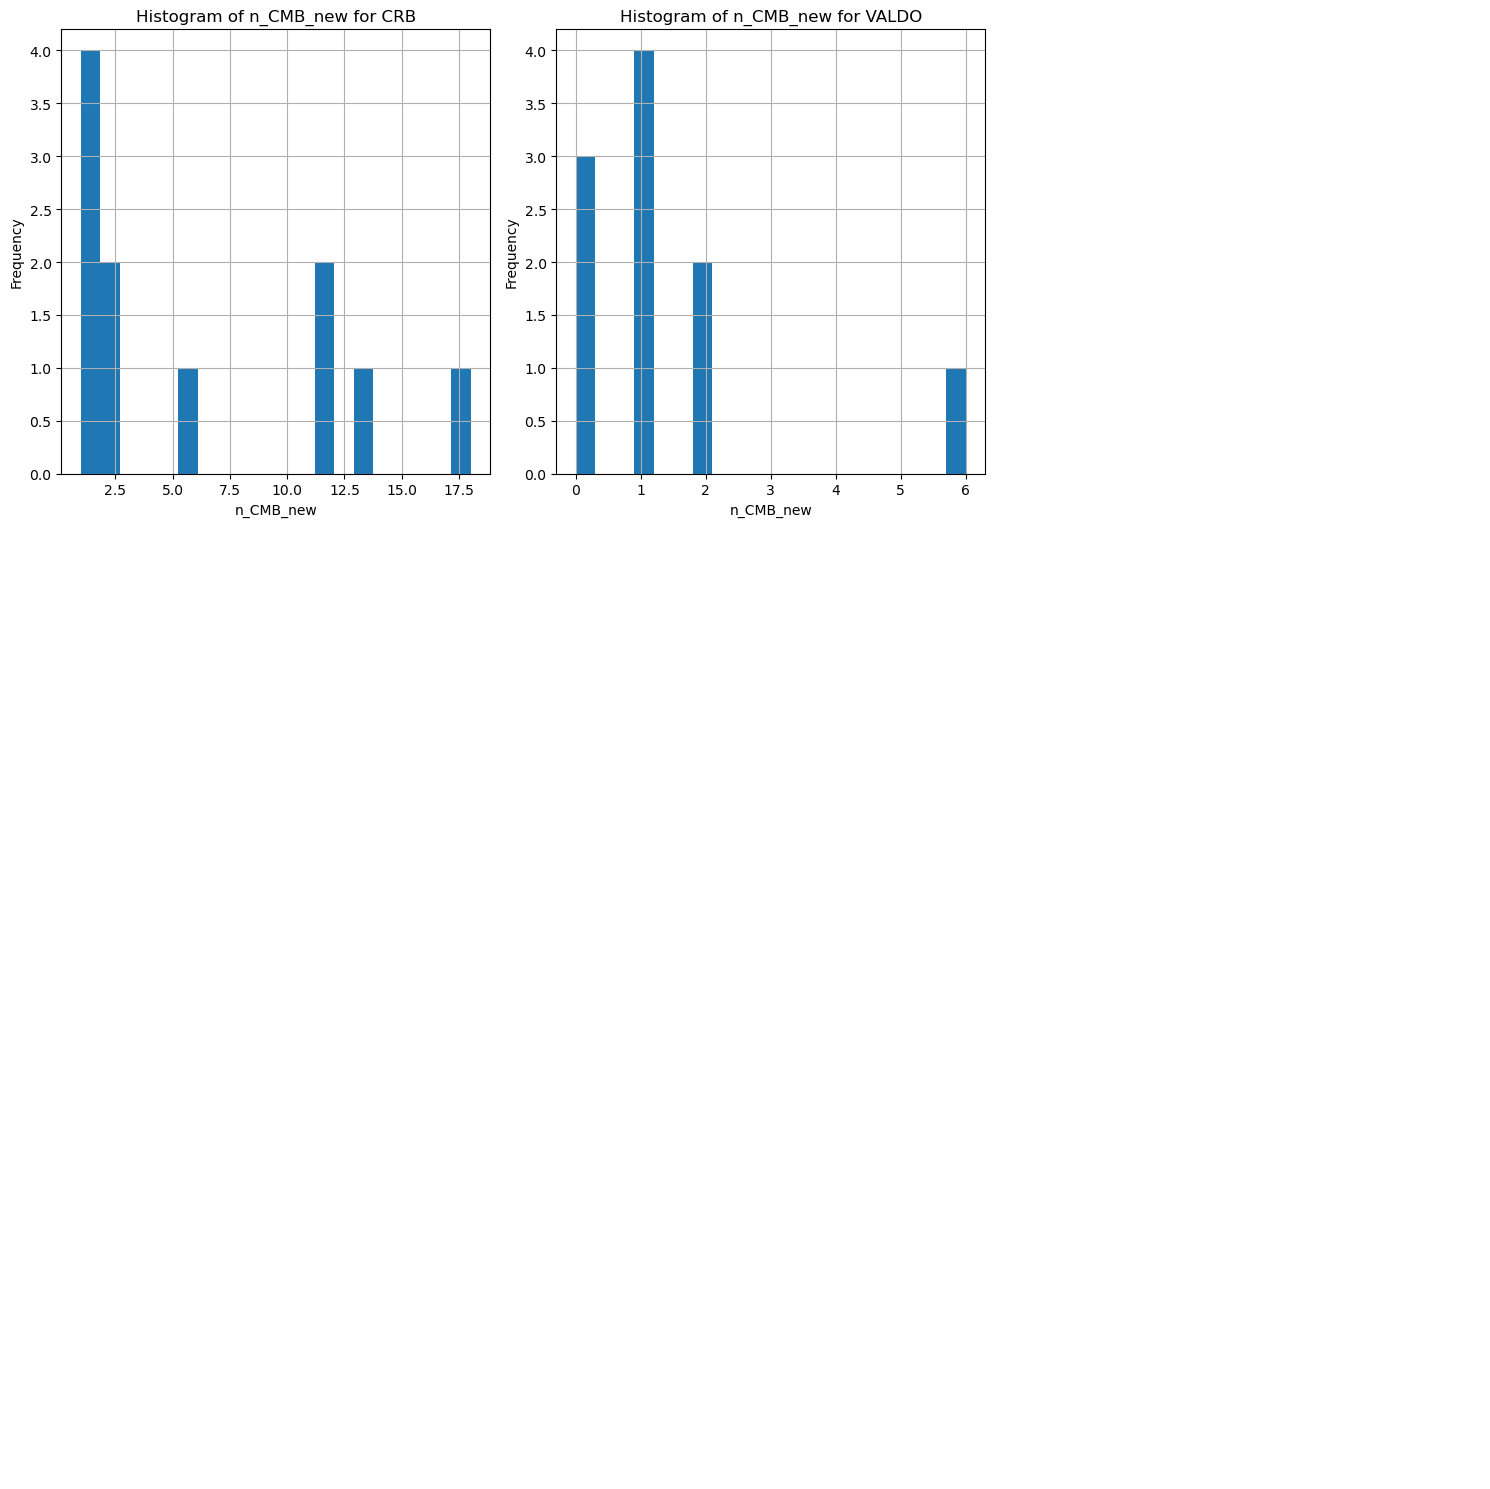

In [5]:
import matplotlib.pyplot as plt

# Filter the DataFrame
filtered_data = all_studies_testing[all_studies_testing['seq_type']=="T2S"]

# Get unique datasets
unique_datasets = filtered_data['Dataset'].unique()

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
axs = axs.flatten()  # Flatten the 2D array of axes to simplify the loop

# Loop through the datasets and plot histograms in each subplot
for i, dataset in enumerate(unique_datasets):
    ax = axs[i]  # Select the corresponding subplot
    data_subset = filtered_data[filtered_data['Dataset'] == dataset]
    data_subset['n_CMB_new'].hist(bins=20, ax=ax)
    ax.set_title(f'Histogram of n_CMB_new for {dataset}')
    ax.set_xlabel('n_CMB_new')
    ax.set_ylabel('Frequency')

# If there are more subplots than datasets, turn off the extra subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


# Re-computed macro and micro

In [6]:
print(
    df_detection_serieslevel["Model"].unique(),
    df_detection_serieslevel["Criteria"].unique(),
)
print(
    df_detection_serieslevel.columns
)

['Scratch-Pretrained-FineTuned'] ['valloss']
Index(['Model', 'Dataset', 'Criteria', 'seriesUID', 'Precision', 'Recall',
       'F1', 'FPavg', 'FPcmb', 'TP', 'FP', 'FN', 'n_true_cmb', 'n_pred_cmb'],
      dtype='object')


In [7]:
aggregations = {
    'Precision': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std', 'count'],
    'F1': ['mean', 'std', 'count'],
    'FPavg': ['mean', 'std', 'count'],
    'FPcmb': ['mean', 'std', 'count'],
    'TP': ['sum', 'mean'],
    'FP': ['sum', 'mean'],
    'FN': ['sum', 'mean'],
    'n_true_cmb': ['sum'],
    'n_pred_cmb': ['sum'],
}

## Number of microbleeds per scan

In [8]:
all_studies_df.columns

Index(['seriesUID', 'series', 'n_CMB_new', 'seq_type', 'res_level', 'healthy',
       'healthy_all', 'field_strength', 'TE', 'subject', 'patientUID',
       'Dataset', 'n_CMB_old', 'old_shape', 'new_shape', 'old_voxel_dim',
       'new_voxel_dim', 'old_orientation', 'new_orientation', 'studyUID_old',
       'n_indataset', 'newCMB', 'diffCMB', 'nCMB_avg', 'CMB_level'],
      dtype='object')

In [9]:
all_studies_testing

,seriesUID,series,n_CMB_new,seq_type,res_level,healthy,healthy_all,field_strength,TE,subject,patientUID,Dataset,n_CMB_old,old_shape,new_shape,old_voxel_dim,new_voxel_dim,old_orientation,new_orientation,studyUID_old,n_indataset,newCMB,diffCMB,nCMB_avg,CMB_level
0,RODEJA-00001-CMB-2,00001-CMB,2,SWI,high,no,False,1.5/3,NaN,00001,00001,RODEJA,2,"[768, 768, 49]","[309, 369, 298]","[0.2994791567325592, 0.2994791567325592, 2.9999923706054688]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00001,1,False,False,2.0,low
5,RODEJA-00008-CMB-1,00008-CMB,1,SWI,high,no,False,1.5/3,NaN,00008,00008,RODEJA,1,"[768, 768, 153]","[306, 411, 357]","[0.2994791567325592, 0.2994791567325592, 1.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00008,6,False,False,1.0,low
16,RODEJA-00023-H,00023-H,0,SWI,low,yes,True,1.5/3,NaN,00023,00023,RODEJA,0,"[224, 256, 64]","[320, 409, 370]","[0.8984375, 0.8984375, 2.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00023,17,False,False,0.0,NaN
27,RODEJA-00036-H,00036-H,0,SWI,low,yes,True,1.5/3,NaN,00036,00036,RODEJA,0,"[224, 256, 72]","[335, 441, 423]","[0.8984375, 0.8984375, 2.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00036,28,False,False,0.0,NaN
34,RODEJA-00046-H,00046-H,0,SWI,high,yes,True,1.5/3,NaN,00046,00046,RODEJA,0,"[768, 768, 153]","[309, 375, 316]","[0.2994791567325592, 0.2994791567325592, 1.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00046,35,False,False,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,VALDO-305-CMB-2,305-CMB,2,T2S,low,no,False,1.5/3,25.0,sub-305,305val,VALDO,2,"[256, 256, 39]","[292, 368, 247]","[1.0, 1.0, 3.0000741481781006]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-305,50,False,False,2.0,low
4818,VALDO-320-CMB-2,320-CMB,2,T2S,low,no,False,1.5/3,25.0,sub-320,320val,VALDO,2,"[256, 256, 39]","[273, 326, 214]","[1.0, 1.0, 2.99997615814209]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-320,65,False,False,2.0,low
4822,VALDO-324-CMB-1,324-CMB,1,T2S,low,no,False,1.5/3,25.0,sub-324,324val,VALDO,1,"[256, 256, 39]","[283, 366, 239]","[1.0, 1.0, 3.000016927719116]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-324,69,False,False,1.0,low
4851,CRB-42a2a5865709f9ddc47da60a1556f09552586685-CMB-6,42a2a5865709f9ddc47da60a1556f09552586685-CMB,6,T2S,high,no,False,1.5/3,32.5,42a2a5865709f9ddc47da60a1556f09552586685,42a2a5865709f9ddc47da60a1556f09552586685,CRB,6,"[512, 512, 60]","[310, 353, 309]","[0.46880000829696655, 0.46879997849464417, 2.3000869750976562]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",42a2a5865709f9ddc47da60a1556f09552586685,17,False,False,6.0,high


In [10]:
# lft join all study df
df_detection_serieslevel = pd.merge(
    df_detection_serieslevel,
    all_studies_testing[
        [
            "seriesUID",
            "seq_type",
            "CMB_level",
            "res_level",
            "n_CMB_new",
            "field_strength",
            "TE",
            "old_shape",
            "old_voxel_dim",
        ]
    ],
    on="seriesUID",
    how="left",
)

# Sequence type

In [11]:
filtered_data = all_studies_testing

studies_normal_count = filtered_data['seriesUID']

# Macro
df_detection_serieslevel_normalcount = df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(studies_normal_count)]
print(
    f"Filtered data from {len(df_detection_serieslevel)} to {len(df_detection_serieslevel_normalcount)}"
)

Filtered data from 78 to 78


In [12]:
import pandas as pd
groups= ['Dataset', 'seq_type', 'CMB_level']
# Define the aggregation dictionary with additional standard deviation calculations
agg_dict = {
    "TP": "sum",
    "FP": "sum",
    "FN": "sum",
    "n_true_cmb": "sum",
    "n_pred_cmb": "sum",
    "Precision": ["mean", "std"],
    "Recall": ["mean", "std"],
    "F1": ["mean", "std"]
}

# Perform the aggregation
grouped_stats = df_detection_serieslevel_normalcount.groupby(groups).agg(agg_dict).reset_index().round(3)

# Flatten the MultiIndex columns
grouped_stats.columns = [' '.join(col).strip() if col[1] else col[0] for col in grouped_stats.columns.values]

# Create "mean ± std" columns for Precision, Recall, and F1
for metric in ["Precision", "Recall", "F1"]:
    mean_col = f"{metric} mean"
    std_col = f"{metric} std"
    grouped_stats[f"{metric} mean±std"] = grouped_stats[mean_col].astype(str) + " ± " + grouped_stats[std_col].astype(str)


# Get F1*
grouped_stats['F1*'] = (
    2 * grouped_stats['Precision mean'] * grouped_stats['Recall mean']
) / (
    grouped_stats['Precision mean'] + grouped_stats['Recall mean']
)
grouped_stats['F1*'] = grouped_stats['F1*'].round(3)  # Optional rounding
# Drop the original mean and std columns for clean presentation
grouped_stats.drop(columns=[f"{metric} mean" for metric in ["Precision", "Recall", "F1"]] + 
                   [f"{metric} std" for metric in ["Precision", "Recall", "F1"]], inplace=True)

# remove l mean±std from names
grouped_stats.columns = [col.replace(" mean±std", "") for col in grouped_stats.columns]
grouped_stats.columns = [col.replace(" sum", "") for col in grouped_stats.columns]
grouped_stats.drop(columns=["n_true_cmb", "n_pred_cmb"], inplace=True)

grouped_stats['globPrecision'] = grouped_stats['TP'] / (grouped_stats['TP'] + grouped_stats['FP'])
grouped_stats['globRecall'] = grouped_stats['TP'] / (grouped_stats['TP'] + grouped_stats['FN'])
grouped_stats['globF1'] = 2 * grouped_stats['globPrecision'] * grouped_stats['globRecall'] / (grouped_stats['globPrecision'] + grouped_stats['globRecall'])

In [13]:
grouped_stats.drop(columns=['globPrecision', 'globRecall'], inplace=True)

In [14]:
grouped_stats

,Dataset,seq_type,CMB_level,TP,FP,FN,Precision,Recall,F1,F1*,globF1
0,crb,SWI,high,24,7,29,0.875 ± 0.182,0.415 ± 0.262,0.494 ± 0.213,0.563,0.571429
1,crb,SWI,low,1,0,4,1.0 ± nan,0.167 ± 0.236,0.5 ± nan,0.286,0.333333
2,crb,T2S,high,9,3,52,0.817 ± 0.171,0.152 ± 0.057,0.25 ± 0.079,0.256,0.246575
3,crb,T2S,low,4,6,4,0.55 ± 0.332,0.5 ± 0.447,0.542 ± 0.16,0.524,0.444444
4,dou,SWI,high,33,7,21,0.903 ± 0.156,0.645 ± 0.23,0.726 ± 0.173,0.753,0.702128
5,dou,SWI,low,18,3,2,0.917 ± 0.207,0.857 ± 0.363,0.942 ± 0.151,0.886,0.878049
6,valid,SWI,high,44,23,19,0.723 ± 0.242,0.71 ± 0.093,0.695 ± 0.136,0.716,0.676923
7,valid,SWI,low,14,15,6,0.532 ± 0.458,0.786 ± 0.384,0.794 ± 0.236,0.635,0.571429
8,valid,T2S,high,6,1,0,0.857 ± nan,1.0 ± nan,0.923 ± nan,0.923,0.923077
9,valid,T2S,low,7,1,1,0.917 ± 0.204,0.917 ± 0.204,0.889 ± 0.172,0.917,0.875000


In [15]:
# Convert to LaTeX
latex_table = grouped_stats.to_latex(index=False, escape=False, column_format='ll' + 'c'*5)
print(latex_table)

\begin{tabular}{llccccc}
\toprule
Dataset & seq_type & CMB_level & TP & FP & FN & Precision & Recall & F1 & F1* & globF1 \\
\midrule
crb & SWI & high & 24 & 7 & 29 & 0.875 ± 0.182 & 0.415 ± 0.262 & 0.494 ± 0.213 & 0.563000 & 0.571429 \\
crb & SWI & low & 1 & 0 & 4 & 1.0 ± nan & 0.167 ± 0.236 & 0.5 ± nan & 0.286000 & 0.333333 \\
crb & T2S & high & 9 & 3 & 52 & 0.817 ± 0.171 & 0.152 ± 0.057 & 0.25 ± 0.079 & 0.256000 & 0.246575 \\
crb & T2S & low & 4 & 6 & 4 & 0.55 ± 0.332 & 0.5 ± 0.447 & 0.542 ± 0.16 & 0.524000 & 0.444444 \\
dou & SWI & high & 33 & 7 & 21 & 0.903 ± 0.156 & 0.645 ± 0.23 & 0.726 ± 0.173 & 0.753000 & 0.702128 \\
dou & SWI & low & 18 & 3 & 2 & 0.917 ± 0.207 & 0.857 ± 0.363 & 0.942 ± 0.151 & 0.886000 & 0.878049 \\
valid & SWI & high & 44 & 23 & 19 & 0.723 ± 0.242 & 0.71 ± 0.093 & 0.695 ± 0.136 & 0.716000 & 0.676923 \\
valid & SWI & low & 14 & 15 & 6 & 0.532 ± 0.458 & 0.786 ± 0.384 & 0.794 ± 0.236 & 0.635000 & 0.571429 \\
valid & T2S & high & 6 & 1 & 0 & 0.857 ± nan & 1.0 ± na

In [16]:
tmp_stud = all_studies_testing[(all_studies_testing['Dataset'] == "CRB") & (all_studies_testing['seq_type'] == "SWI") ]['seriesUID']
df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(tmp_stud)]

,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,seq_type,CMB_level,res_level,n_CMB_new,field_strength,TE,old_shape,old_voxel_dim
69,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.840.113845.11.1000000001815528930.20201010223701.3603014-CMB-4,0.600000,0.750000,0.666667,2.0,0.500000,3,2,1,4,5,SWI,high,low,4,1.5/3,32.5,"[208, 256, 80]","[0.859375, 0.859375, 1.8999617099761963]"
70,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.840.113845.13.13849.872975378.634767293118-CMB-29,0.772727,0.586207,0.666667,5.0,0.172414,17,5,12,29,22,SWI,high,low,29,1.5/3,32.5,"[208, 256, 88]","[0.9765620231628418, 0.9765620231628418, 1.900075078010559]"
71,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.840.113845.13.14537.872975378.3343495815236-CMB-3,1.000000,0.333333,0.500000,0.0,0.000000,1,0,2,3,1,SWI,low,low,3,1.5/3,32.5,"[208, 256, 80]","[0.8593750596046448, 0.859375, 1.8999590873718262]"
72,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000043-CMB-4,1.000000,0.250000,0.400000,0.0,0.000000,1,0,3,4,1,SWI,high,low,4,1.5/3,32.5,"[192, 256, 56]","[0.8984374403953552, 0.8984375, 2.4999992847442627]"
73,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000049-CMB-2,NaN,0.000000,NaN,0.0,0.000000,0,0,2,2,0,SWI,low,low,2,1.5/3,32.5,"[192, 256, 52]","[0.8984375, 0.8984375, 2.500000476837158]"
74,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000001-CMB-5,1.000000,0.400000,0.571429,0.0,0.000000,2,0,3,5,2,SWI,high,low,5,1.5/3,32.5,"[208, 256, 52]","[0.8984375, 0.8984375, 2.5]"
75,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000040-CMB-11,1.000000,0.090909,0.166667,0.0,0.000000,1,0,10,11,1,SWI,high,low,11,1.5/3,32.5,"[208, 256, 52]","[0.8984375, 0.8984375, 2.499998092651367]"


In [17]:
all_studies_testing[(all_studies_testing['Dataset'].isin(["RODEJA", 'VALDO', 'MOMENI'])) & (all_studies_testing['seq_type'] == "T2S")]


,seriesUID,series,n_CMB_new,seq_type,res_level,healthy,healthy_all,field_strength,TE,subject,patientUID,Dataset,n_CMB_old,old_shape,new_shape,old_voxel_dim,new_voxel_dim,old_orientation,new_orientation,studyUID_old,n_indataset,newCMB,diffCMB,nCMB_avg,CMB_level
673,VALDO-103-CMB-6,103-CMB,6,T2S,high,no,False,1.5/3,25.0,sub-103,103val,VALDO,6,"[512, 512, 35]","[298, 381, 291]","[0.4492187201976776, 0.4492187798023224, 4.0]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-103,3,False,False,6.0,high
674,VALDO-104-H,104-H,0,T2S,high,yes,True,1.5/3,25.0,sub-104,104val,VALDO,0,"[512, 512, 35]","[323, 366, 349]","[0.4492187201976776, 0.44921875, 4.0]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-104,4,False,False,0.0,NaN
1779,VALDO-205-H,205-H,0,T2S,high,yes,True,1.5/3,25.0,sub-205,205val,VALDO,0,"[512, 512, 192]","[287, 331, 283]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-205,16,False,False,0.0,NaN
1780,VALDO-206-H,206-H,0,T2S,high,yes,True,1.5/3,25.0,sub-206,206val,VALDO,0,"[512, 512, 192]","[259, 312, 280]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-206,17,False,False,0.0,NaN
1848,VALDO-208-CMB-1,208-CMB,1,T2S,high,no,False,1.5/3,25.0,sub-208,208val,VALDO,1,"[512, 512, 192]","[265, 334, 275]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-208,19,False,False,1.0,low
2738,VALDO-232-CMB-1,232-CMB,1,T2S,high,no,False,1.5/3,25.0,sub-232,232val,VALDO,1,"[512, 512, 192]","[270, 315, 270]","[0.4882810115814209, 0.4882810115814209, 0.800000011920929]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-232,43,False,False,1.0,low
4698,VALDO-302-CMB-1,302-CMB,1,T2S,low,no,False,1.5/3,25.0,sub-302,302val,VALDO,1,"[256, 256, 39]","[287, 351, 237]","[1.0, 1.0, 3.0000433921813965]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-302,47,False,False,1.0,low
4734,VALDO-305-CMB-2,305-CMB,2,T2S,low,no,False,1.5/3,25.0,sub-305,305val,VALDO,2,"[256, 256, 39]","[292, 368, 247]","[1.0, 1.0, 3.0000741481781006]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-305,50,False,False,2.0,low
4818,VALDO-320-CMB-2,320-CMB,2,T2S,low,no,False,1.5/3,25.0,sub-320,320val,VALDO,2,"[256, 256, 39]","[273, 326, 214]","[1.0, 1.0, 2.99997615814209]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-320,65,False,False,2.0,low
4822,VALDO-324-CMB-1,324-CMB,1,T2S,low,no,False,1.5/3,25.0,sub-324,324val,VALDO,1,"[256, 256, 39]","[283, 366, 239]","[1.0, 1.0, 3.000016927719116]","[0.5, 0.5, 0.5]","['L', 'A', 'S']","['R', 'A', 'S']",sub-324,69,False,False,1.0,low


In [18]:
df_detection_serieslevel[df_detection_serieslevel['CMB_level'] == "high"]

,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,seq_type,CMB_level,res_level,n_CMB_new,field_strength,TE,old_shape,old_voxel_dim
3,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00070-CMB-10,0.888889,0.800000,0.842105,1.0,0.100000,8,1,2,10,9,SWI,high,high,10,1.5/3,NaN,"[768, 768, 140]","[0.2994791567325592, 0.2994791567325592, 1.0]"
5,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00100-CMB-9,0.388889,0.777778,0.518519,11.0,1.222222,7,11,2,9,18,SWI,high,high,9,1.5/3,NaN,"[768, 768, 124]","[0.2994791567325592, 0.2994791567325592, 1.0]"
8,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00116-CMB-11,1.000000,0.636364,0.777778,0.0,0.000000,7,0,4,11,7,SWI,high,high,11,1.5/3,NaN,"[768, 768, 153]","[0.2994791567325592, 0.2994791567325592, 1.0]"
12,Scratch-Pretrained-FineTuned,valid,valloss,VALDO-103-CMB-6,0.857143,1.000000,0.923077,1.0,0.166667,6,1,0,6,7,T2S,high,high,6,1.5/3,25.0,"[512, 512, 35]","[0.4492187201976776, 0.4492187798023224, 4.0]"
35,Scratch-Pretrained-FineTuned,valid,valloss,MOMENI-305_T0-CMB-16,0.750000,0.750000,0.750000,4.0,0.250000,12,4,4,16,16,SWI,high,low,16,3,20.0,"[176, 256, 80]","[0.9375000596046448, 0.9375, 1.7500004768371582]"
36,Scratch-Pretrained-FineTuned,valid,valloss,MOMENI-305_T1-CMB-17,0.588235,0.588235,0.588235,7.0,0.411765,10,7,7,17,17,SWI,high,low,17,3,20.0,"[176, 256, 80]","[0.9375, 0.9375, 1.7499996423721313]"
42,Scratch-Pretrained-FineTuned,dou,valloss,DOU-03-CMB-4,1.000000,1.000000,1.000000,0.0,0.000000,4,0,0,4,4,SWI,high,high,4,3,24.0,"[512, 512, 150]","[0.44921875, 0.44921875, 0.9999327659606934]"
48,Scratch-Pretrained-FineTuned,dou,valloss,DOU-09-CMB-11,1.000000,0.363636,0.533333,0.0,0.000000,4,0,7,11,4,SWI,high,high,11,3,24.0,"[512, 512, 150]","[0.44921875, 0.44921875, 1.0000038146972656]"
49,Scratch-Pretrained-FineTuned,dou,valloss,DOU-10-CMB-8,1.000000,0.750000,0.857143,0.0,0.000000,6,0,2,8,6,SWI,high,high,8,3,24.0,"[512, 512, 150]","[0.44921875, 0.44921875, 1.0000076293945312]"
54,Scratch-Pretrained-FineTuned,dou,valloss,DOU-15-CMB-13,0.642857,0.692308,0.666667,5.0,0.384615,9,5,4,13,14,SWI,high,high,13,3,24.0,"[342, 410, 150]","[0.44921875, 0.44921875, 0.9999896883964539]"


# Resolution

In [19]:
df_detection_serieslevel['z_dim'] = df_detection_serieslevel['old_voxel_dim'].apply(lambda x: ast.literal_eval(x)[-1])
df_detection_serieslevel[['z_dim', 'old_voxel_dim']]
df_detection_serieslevel['slice_thickness'] = df_detection_serieslevel['z_dim'].apply(lambda x: "small" if x < 3 else "large")
df_detection_serieslevel.groupby(['Dataset','slice_thickness']).size()

Dataset  slice_thickness
crb      large              10
         small               8
dou      small              20
valid    large               6
         small              34
dtype: int64

In [20]:
filtered_data = all_studies_testing
studies_normal_count = filtered_data['seriesUID']

# groups = ['Dataset', 'seq_type','slice_thickness', "CMB_level"]
groups = ['Dataset', 'res_level']

# Macro
df_detection_serieslevel_normalcount = df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(studies_normal_count)]
print(
    f"Filtered data from {len(df_detection_serieslevel)} to {len(df_detection_serieslevel_normalcount)}"
)
df_detection_serieslevel_macro = df_detection_serieslevel_normalcount.groupby(groups).agg(aggregations).round(2)
# F1*
df_detection_serieslevel_macro['F1*'] = (2 * (df_detection_serieslevel_macro['Precision']['mean'] * df_detection_serieslevel_macro['Recall']['mean']) )/ (df_detection_serieslevel_macro['Precision']['mean'] + df_detection_serieslevel_macro['Recall']['mean'])



# Micro
global_cm = df_detection_serieslevel_normalcount.groupby(groups).agg(
 {
    'TP': ['sum'],
    'FP': ['sum'],
    'FN': ['sum'],
    'seriesUID': ['count'],
}   
    
    ).round(2)

global_cm.reset_index(inplace=True)
global_cm.columns = global_cm.columns.droplevel(1)
df_detection_serieslevel_micro = global_cm.copy()
df_detection_serieslevel_micro['Precision'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FP'])
df_detection_serieslevel_micro['Recall'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['F1'] = 2 * (df_detection_serieslevel_micro['Precision'] * df_detection_serieslevel_micro['Recall']) / (df_detection_serieslevel_micro['Precision'] + df_detection_serieslevel_micro['Recall'])
df_detection_serieslevel_micro['FPavg'] = df_detection_serieslevel_micro['FP'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro['FPcmb'] = df_detection_serieslevel_micro['FP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['FNavg'] = df_detection_serieslevel_micro['FN'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro['FNcmb'] = df_detection_serieslevel_micro['FN'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['FNscan'] = df_detection_serieslevel_micro['FN'] / (df_detection_serieslevel_micro['seriesUID'])


df_detection_serieslevel_micro.round(3)


Filtered data from 78 to 78


,Dataset,res_level,TP,FP,FN,seriesUID,Precision,Recall,F1,FPavg,FPcmb,FNavg,FNcmb,FNscan
0,crb,high,11,8,46,10,0.579,0.193,0.289,0.800,0.140,4.600,0.807,4.600
1,crb,low,27,8,43,8,0.771,0.386,0.514,1.000,0.114,5.375,0.614,5.375
2,dou,high,51,10,23,20,0.836,0.689,0.756,0.500,0.135,1.150,0.311,1.150
3,valid,high,36,28,13,16,0.562,0.735,0.637,1.750,0.571,0.812,0.265,0.812
4,valid,low,35,40,13,24,0.467,0.729,0.569,1.667,0.833,0.542,0.271,0.542


In [21]:
df_detection_serieslevel_macro['Recall']['mean']

Dataset  res_level
crb      high         0.36
         low          0.32
dou      high         0.79
valid    high         0.77
         low          0.85
Name: mean, dtype: float64

Dataset  seq_type
crb      SWI         Axes(0.125,0.11;0.775x0.77)
         T2S         Axes(0.125,0.11;0.775x0.77)
dou      SWI         Axes(0.125,0.11;0.775x0.77)
valid    SWI         Axes(0.125,0.11;0.775x0.77)
         T2S         Axes(0.125,0.11;0.775x0.77)
Name: z_dim, dtype: object

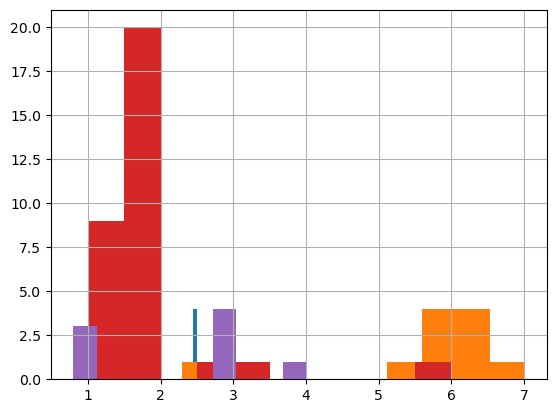

In [22]:
df_detection_serieslevel.groupby(["Dataset", "seq_type"])['z_dim'].hist()

In [23]:
df_detection_serieslevel_macro

Precision             Recall                F1              \
                       mean   std count   mean   std count  mean   std count   
Dataset res_level                                                              
crb     high           0.70  0.29     8   0.36  0.38    10  0.39  0.20     8   
        low            0.86  0.18     7   0.32  0.25     8  0.46  0.19     7   
dou     high           0.91  0.19    18   0.79  0.34    20  0.87  0.19    18   
valid   high           0.55  0.43    15   0.77  0.32    12  0.72  0.22    11   
        low            0.47  0.47    24   0.85  0.30    14  0.87  0.17    13   

                  FPavg             FPcmb              TP        FP        FN  \
                   mean   std count  mean   std count sum  mean sum  mean sum   
Dataset res_level                                                               
crb     high       0.80  1.23    10  0.56  1.25    10  11  1.10   8  0.80  46   
        low        1.00  1.77     8  0.09  0.18     8  27  3.38   8  1.00  43   
dou     high       0.50  1.24    20  0.15  0.46    20  51  2.55  10  0.50  23   
valid   high       1.75  2.77    16  0.62  0.99    12  36  2.25  28  1.75  13   
        low        1.67  2.88    24  0.26  0.42    14  35  1.46  40  1.67  13   

                        n_true_cmb n_pred_cmb       F1*  
                   mean        sum        sum            
Dataset res_level                                        
crb     high       4.60         57         20  0.475472  
        low        5.38         70         35  0.466441  
dou     high       1.15         74         62  0.845765  
valid   high       0.81         49         64  0.641667  
        low        0.54         48         75  0.605303

# TE, TR

Dataset
CRB       Axes(0.125,0.11;0.775x0.77)
DOU       Axes(0.125,0.11;0.775x0.77)
MOMENI    Axes(0.125,0.11;0.775x0.77)
VALDO     Axes(0.125,0.11;0.775x0.77)
Name: TE, dtype: object

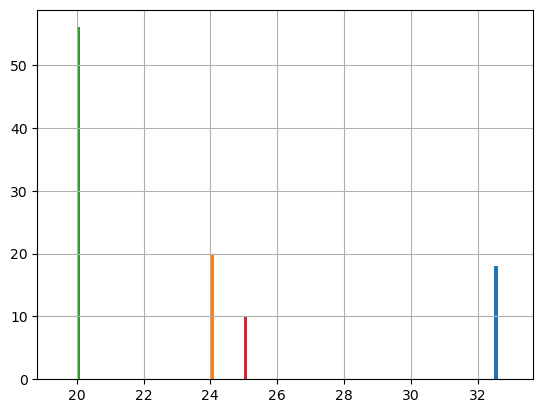

In [24]:
filtered_data.shape
filtered_data[~filtered_data['TE'].isnull()].groupby("Dataset")['TE'].hist()

In [25]:
filtered_data = all_studies_testing
studies_normal_count = filtered_data['seriesUID']

groups = ['Dataset', 'TE']


# Macro
df_detection_serieslevel_normalcount = df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(studies_normal_count)]
print(
    f"Filtered data from {len(df_detection_serieslevel)} to {len(df_detection_serieslevel_normalcount)}"
)
df_detection_serieslevel_macro = df_detection_serieslevel_normalcount.groupby(groups).agg(aggregations).round(2)
# F1*
df_detection_serieslevel_macro['F1*'] = (2 * (df_detection_serieslevel_macro['Precision']['mean'] * df_detection_serieslevel_macro['Recall']['mean']) )/ (df_detection_serieslevel_macro['Precision']['mean'] + df_detection_serieslevel_macro['Recall']['mean'])



# Micro
global_cm = df_detection_serieslevel_normalcount.groupby(groups).agg(
 {
    'TP': ['sum'],
    'FP': ['sum'],
    'FN': ['sum'],
    'seriesUID': ['count'],
}   
    
    ).round(2)

global_cm.reset_index(inplace=True)
global_cm.columns = global_cm.columns.droplevel(1)
df_detection_serieslevel_micro = global_cm.copy()
df_detection_serieslevel_micro['Precision'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FP'])
df_detection_serieslevel_micro['Recall'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['F1'] = 2 * (df_detection_serieslevel_micro['Precision'] * df_detection_serieslevel_micro['Recall']) / (df_detection_serieslevel_micro['Precision'] + df_detection_serieslevel_micro['Recall'])
df_detection_serieslevel_micro['FPavg'] = df_detection_serieslevel_micro['FP'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro['FPcmb'] = df_detection_serieslevel_micro['FP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['FNavg'] = df_detection_serieslevel_micro['FN'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro['FNcmb'] = df_detection_serieslevel_micro['FN'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['FNscan'] = df_detection_serieslevel_micro['FN'] / (df_detection_serieslevel_micro['seriesUID'])


df_detection_serieslevel_micro.round(3)


Filtered data from 78 to 78


,Dataset,TE,TP,FP,FN,seriesUID,Precision,Recall,F1,FPavg,FPcmb,FNavg,FNcmb,FNscan
0,crb,32.5,38,16,89,18,0.704,0.299,0.420,0.889,0.126,4.944,0.701,4.944
1,dou,24.0,51,10,23,20,0.836,0.689,0.756,0.500,0.135,1.150,0.311,1.150
2,valid,20.0,30,39,12,20,0.435,0.714,0.541,1.950,0.929,0.600,0.286,0.600
3,valid,25.0,13,3,1,8,0.812,0.929,0.867,0.375,0.214,0.125,0.071,0.125


In [26]:
df_detection_serieslevel['x dim'] = df_detection_serieslevel['old_voxel_dim'].apply(lambda x: ast.literal_eval(x)[0])
df_detection_serieslevel['y dim'] = df_detection_serieslevel['old_voxel_dim'].apply(lambda x: ast.literal_eval(x)[1])
df_detection_serieslevel['z dim'] = df_detection_serieslevel['old_voxel_dim'].apply(lambda x: ast.literal_eval(x)[2])

In [27]:
df_detection_serieslevel['x dim'].max()

1.0

In [28]:
df_detection_serieslevel

,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,seq_type,CMB_level,res_level,n_CMB_new,field_strength,TE,old_shape,old_voxel_dim,z_dim,slice_thickness,x dim,y dim,z dim
0,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00001-CMB-2,NaN,0.000000,NaN,0.0,0.0,0,0,2,2,0,SWI,low,high,2,1.5/3,NaN,"[768, 768, 49]","[0.2994791567325592, 0.2994791567325592, 2.9999923706054688]",2.999992,small,0.299479,0.299479,2.999992
1,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00008-CMB-1,0.500000,1.000000,0.666667,1.0,1.0,1,1,0,1,2,SWI,low,high,1,1.5/3,NaN,"[768, 768, 153]","[0.2994791567325592, 0.2994791567325592, 1.0]",1.000000,small,0.299479,0.299479,1.000000
2,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00051-CMB-3,1.000000,0.666667,0.800000,0.0,0.0,2,0,1,3,2,SWI,low,high,3,1.5/3,NaN,"[768, 768, 50]","[0.2994791567325592, 0.2994791567325592, 3.0]",3.000000,large,0.299479,0.299479,3.000000
3,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00070-CMB-10,0.888889,0.800000,0.842105,1.0,0.1,8,1,2,10,9,SWI,high,high,10,1.5/3,NaN,"[768, 768, 140]","[0.2994791567325592, 0.2994791567325592, 1.0]",1.000000,small,0.299479,0.299479,1.000000
4,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00095-H,0.000000,NaN,NaN,1.0,NaN,0,1,0,0,1,SWI,NaN,high,0,1.5/3,NaN,"[768, 768, 140]","[0.2994791567325592, 0.2994791567325592, 1.0]",1.000000,small,0.299479,0.299479,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000049-CMB-2,NaN,0.000000,NaN,0.0,0.0,0,0,2,2,0,SWI,low,low,2,1.5/3,32.5,"[192, 256, 52]","[0.8984375, 0.8984375, 2.500000476837158]",2.500000,small,0.898438,0.898438,2.500000
74,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000001-CMB-5,1.000000,0.400000,0.571429,0.0,0.0,2,0,3,5,2,SWI,high,low,5,1.5/3,32.5,"[208, 256, 52]","[0.8984375, 0.8984375, 2.5]",2.500000,small,0.898438,0.898438,2.500000
75,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000040-CMB-11,1.000000,0.090909,0.166667,0.0,0.0,1,0,10,11,1,SWI,high,low,11,1.5/3,32.5,"[208, 256, 52]","[0.8984375, 0.8984375, 2.499998092651367]",2.499998,small,0.898438,0.898438,2.499998
76,Scratch-Pretrained-FineTuned,crb,valloss,CRB-42a2a5865709f9ddc47da60a1556f09552586685-CMB-6,1.000000,0.166667,0.285714,0.0,0.0,1,0,5,6,1,T2S,high,high,6,1.5/3,32.5,"[512, 512, 60]","[0.46880000829696655, 0.46879997849464417, 2.3000869750976562]",2.300087,small,0.468800,0.468800,2.300087


In [29]:
df_detection_serieslevel[
    # df_detection_serieslevel["CM"] == "(188, 240, 93)" & 
    df_detection_serieslevel["seriesUID"]== "CRB-1.2.826.1.3680043.9.5282.150415.650.650232327158-CMB-13"
]


,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,seq_type,CMB_level,res_level,n_CMB_new,field_strength,TE,old_shape,old_voxel_dim,z_dim,slice_thickness,x dim,y dim,z dim
68,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.2.826.1.3680043.9.5282.150415.650.650232327158-CMB-13,0.75,0.230769,0.352941,1.0,0.076923,3,1,10,13,5,T2S,high,high,13,1.5/3,32.5,"[400, 512, 26]","[0.4492189884185791, 0.4492189884185791, 6.0]",6.0,large,0.449219,0.449219,6.0


In [30]:
all_studies_df[all_studies_df['Dataset'] == "MOMENI"].groupby("seq_type").size()

seq_type
SWI    370
dtype: int64

In [31]:
cr_path_Studi = ["1.2.826.1.3680043.9.5282.150415.14832.16014832222376"    ,     "1.2.826.1.3680043.9.5282.150415.178.178232327158"  ,          
"1.2.826.1.3680043.9.5282.150415.34194.3419422232714"     ,     "1.2.840.113845.11.1000000001815528930.20201010223701.3603014",
"1.2.840.113845.13.13849.872975378.634767293118"         ,      "1.2.840.113845.13.14537.872975378.3343495815236"          ,   
"1.3.12.2.1107.5.2.6.24111.30000019082703511493700000001"   ,   "1.3.12.2.1107.5.2.6.24111.30000019082703511493700000040"  ,   
"cd562073a877df14df5a16f1aea5d709de641b24"   ]

In [32]:
all_studies_df[all_studies_df['seriesUID'].str.split("-").str[1].isin(cr_path_Studi)][["seq_type", "seriesUID"]].to_csv("/storage/evo1/jorge/patho.csv")